In [1]:
# https://github.com/Kaushalya/medclip/blob/master/tools/test_clip.ipynb
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from jax.config import config
config.update("jax_platform_name", "cpu")
import jax
import sys
import numpy as np
import tensorrt
from transformers import AutoTokenizer, CLIPProcessor
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import Resize, Normalize, ConvertImageDtype, ToTensor

sys.path.append('..')
from medclip.configuration_hybrid_clip import HybridCLIPConfig
# from medclip.modeling_hybrid_clip import FlaxHybridCLIP
from medclip.run_medclip import Transform

In [2]:
from typing import Optional, Tuple

import flax.linen as nn
import jax
import jax.numpy as jnp
from medclip.configuration_hybrid_clip import HybridCLIPConfig
from flax.core.frozen_dict import FrozenDict
from transformers import FLAX_MODEL_MAPPING, FlaxCLIPVisionModel
from transformers.modeling_flax_utils import FlaxPreTrainedModel
from transformers.models.clip.modeling_flax_clip import FlaxCLIPOutput
from transformers.utils import logging


logger = logging.get_logger(__name__)


class FlaxHybridCLIPModule(nn.Module):
    config: HybridCLIPConfig
    dtype: jnp.dtype = jnp.float32
    _do_init: bool = False

    def setup(self):
        text_config = self.config.text_config
        vision_config = self.config.vision_config

        self.projection_dim = self.config.projection_dim
        self.text_embed_dim = text_config.hidden_size
        self.vision_embed_dim = vision_config.hidden_size

        text_module = FLAX_MODEL_MAPPING[self.config.text_config.__class__].module_class
        vision_module = FLAX_MODEL_MAPPING.get(self.config.vision_config.__class__, FlaxCLIPVisionModel).module_class

        self.text_model = text_module(text_config, dtype=self.dtype)
        self.vision_model = vision_module(vision_config, dtype=self.dtype)

        self.visual_projection = nn.Dense(
            self.projection_dim,
            dtype=self.dtype,
            kernel_init=jax.nn.initializers.normal(0.02, dtype=self.dtype),
            use_bias=False,
        )
        self.text_projection = nn.Dense(
            self.projection_dim,
            dtype=self.dtype,
            kernel_init=jax.nn.initializers.normal(0.02, dtype=self.dtype),
            use_bias=False,
        )
        self.logit_scale = self.param("logit_scale", jax.nn.initializers.ones, [])

    def __call__(
        self,
        input_ids=None,
        pixel_values=None,
        attention_mask=None,
        position_ids=None,
        token_type_ids=None,
        deterministic: bool = True,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.return_dict

        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            deterministic=deterministic,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        text_outputs = self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            deterministic=deterministic,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        image_embeds = vision_outputs[1]
        image_embeds = self.visual_projection(image_embeds)

        text_embeds = text_outputs[1]
        text_embeds = self.text_projection(text_embeds)

        # normalized features
        image_embeds = image_embeds / jnp.linalg.norm(image_embeds, axis=-1, keepdims=True)
        text_embeds = text_embeds / jnp.linalg.norm(text_embeds, axis=-1, keepdims=True)

        # cosine similarity as logits
        logit_scale = jnp.exp(self.logit_scale)
        logits_per_text = jnp.matmul(text_embeds, image_embeds.T) * logit_scale
        logits_per_image = logits_per_text.T

        if not return_dict:
            return (logits_per_image, logits_per_text, text_embeds, image_embeds, text_outputs, vision_outputs)

        return FlaxCLIPOutput(
            logits_per_image=logits_per_image,
            logits_per_text=logits_per_text,
            text_embeds=text_embeds,
            image_embeds=image_embeds,
            text_model_output=text_outputs,
            vision_model_output=vision_outputs,
        )


class FlaxHybridCLIP(FlaxPreTrainedModel):
    config_class = HybridCLIPConfig
    module_class = FlaxHybridCLIPModule

    def __init__(
        self,
        config: HybridCLIPConfig,
        input_shape: Optional[Tuple] = None,
        seed: int = 0,
        dtype: jnp.dtype = jnp.float32,
        **kwargs
    ):
        if input_shape is None:
            input_shape = ((1, 1), (1, config.vision_config.image_size, config.vision_config.image_size, 3))

        module = self.module_class(config=config, dtype=dtype, **kwargs)
        super().__init__(config, module, input_shape=input_shape, seed=seed, dtype=dtype)

    # def init_weights(self, rng: jax.random.PRNGKey, input_shape: Tuple) -> FrozenDict:
    #     # init input tensor
    #     input_ids = jnp.zeros(input_shape[0], dtype="i4")
    #     position_ids = jnp.broadcast_to(jnp.arange(jnp.atleast_2d(input_ids).shape[-1]), input_shape[0])
    #     token_type_ids = jnp.ones_like(input_ids)
    #     attention_mask = jnp.ones_like(input_ids)

    #     pixel_values = jax.random.normal(rng, input_shape[1])

    #     params_rng, dropout_rng = jax.random.split(rng)
    #     rngs = {"params": params_rng, "dropout": dropout_rng}

    #     return self.module.init(rngs, input_ids, pixel_values, attention_mask, position_ids, token_type_ids)["params"]

    def __call__(
        self,
        input_ids,
        pixel_values,
        attention_mask=None,
        position_ids=None,
        token_type_ids=None,
        params: dict = None,
        dropout_rng: jax.random.PRNGKey = None,
        train: bool = False,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.return_dict

        if position_ids is None:
            position_ids = jnp.broadcast_to(jnp.arange(jnp.atleast_2d(input_ids).shape[-1]), input_ids.shape)

        if token_type_ids is None:
            token_type_ids = jnp.zeros_like(input_ids)

        if attention_mask is None:
            attention_mask = jnp.ones_like(input_ids)

        # Handle any PRNG if needed
        rngs = {}
        if dropout_rng is not None:
            rngs["dropout"] = dropout_rng

        return self.module.apply(
            {"params": params or self.params},
            jnp.array(input_ids, dtype="i4"),
            jnp.array(pixel_values, dtype=jnp.float32),
            jnp.array(attention_mask, dtype="i4"),
            jnp.array(position_ids, dtype="i4"),
            jnp.array(token_type_ids, dtype="i4"),
            not train,
            output_attentions,
            output_hidden_states,
            return_dict,
            rngs=rngs,
        )

    # def get_text_features(
    #     self,
    #     input_ids,
    #     attention_mask=None,
    #     position_ids=None,
    #     token_type_ids=None,
    #     dropout_rng: jax.random.PRNGKey = None,
    #     train=False,
    # ):
    #     r"""
    #     Args:
    #         input_ids (:obj:`numpy.ndarray` of shape :obj:`(batch_size, sequence_length)`):
    #             Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you
    #             provide it.

    #             Indices can be obtained using :class:`~transformers.PreTrainedTokenizer`. See
    #             :meth:`transformers.PreTrainedTokenizer.encode` and :meth:`transformers.PreTrainedTokenizer.__call__`
    #             for details.

    #             `What are input IDs? <../glossary.html#input-ids>`__

    #     Returns:
    #         text_features (:obj:`jax_xla.DeviceArray` of shape :obj:`(batch_size, output_dim`): The text embeddings
    #         obtained by applying the projection layer to the pooled output of text model.
    #     """
    #     if position_ids is None:
    #         position_ids = jnp.broadcast_to(jnp.arange(jnp.atleast_2d(input_ids).shape[-1]), input_ids.shape)

    #     if token_type_ids is None:
    #         token_type_ids = jnp.zeros_like(input_ids)

    #     if attention_mask is None:
    #         attention_mask = jnp.ones_like(input_ids)

    #     # Handle any PRNG if needed
    #     rngs = {}
    #     if dropout_rng is not None:
    #         rngs["dropout"] = dropout_rng

    #     def _get_features(module, input_ids, attention_mask, position_ids, token_type_ids, deterministic):
    #         text_outputs = module.text_model(
    #             input_ids=input_ids,
    #             attention_mask=attention_mask,
    #             position_ids=position_ids,
    #             token_type_ids=token_type_ids,
    #             deterministic=deterministic,
    #         )
    #         pooled_output = text_outputs[1]
    #         text_features = module.text_projection(pooled_output)
    #         return text_features

    #     return self.module.apply(
    #         {"params": self.params},
    #         jnp.array(input_ids, dtype="i4"),
    #         jnp.array(attention_mask, dtype="i4"),
    #         jnp.array(position_ids, dtype="i4"),
    #         jnp.array(token_type_ids, dtype="i4"),
    #         not train,
    #         method=_get_features,
    #         rngs=rngs,
    #     )

    def get_image_features(self, pixel_values, dropout_rng: jax.random.PRNGKey = None, train=False):
        r"""
        Args:
            pixel_values (:obj:`numpy.ndarray` of shape :obj:`(batch_size, num_channels, height, width)`):
                Pixel values. Padding will be ignored by default should you provide it. Pixel values can be obtained
                using :class:`~transformers.ImageFeatureExtractionMixin`. See
                :meth:`transformers.ImageFeatureExtractionMixin.__call__` for details.

        Returns:
            image_features (:obj:`jax_xla.DeviceArray` of shape :obj:`(batch_size, output_dim`): The image embeddings
            obtained by applying the projection layer to the pooled output of vision model.
        """

        # Handle any PRNG if needed
        rngs = {}
        if dropout_rng is not None:
            rngs["dropout"] = dropout_rng

        def _get_features(module, pixel_values, deterministic):
            vision_outputs = module.vision_model(pixel_values=pixel_values, deterministic=deterministic)
            pooled_output = vision_outputs[1]  # pooled_output
            image_features = module.visual_projection(pooled_output)
            return image_features

        return self.module.apply(
            {"params": self.params},
            jnp.array(pixel_values, dtype=jnp.float32),
            not train,
            method=_get_features,
            rngs=rngs,
        )

    # @classmethod
    # def from_text_vision_pretrained(
    #     cls,
    #     text_model_name_or_path: str = None,
    #     vision_model_name_or_path: str = None,
    #     *model_args,
    #     **kwargs,
    # ) -> FlaxPreTrainedModel:
    #     """
    #     Params:
    #         text_model_name_or_path (:obj: `str`, `optional`):
    #             Information necessary to initiate the text model. Can be either:

    #                 - A string, the `model id` of a pretrained model hosted inside a model repo on huggingface.co.
    #                   Valid model ids can be located at the root-level, like ``bert-base-uncased``, or namespaced under
    #                   a user or organization name, like ``dbmdz/bert-base-german-cased``.
    #                 - A path to a `directory` containing model weights saved using
    #                   :func:`~transformers.FlaxPreTrainedModel.save_pretrained`, e.g., ``./my_model_directory/``.
    #                 - A path or url to a `PyTorch checkpoint folder` (e.g, ``./pt_model``). In
    #                   this case, ``from_pt`` should be set to :obj:`True` and a configuration object should be provided
    #                   as ``config`` argument. This loading path is slower than converting the PyTorch checkpoint in
    #                   a Flax model using the provided conversion scripts and loading the Flax model afterwards.

    #         vision_model_name_or_path (:obj: `str`, `optional`, defaults to `None`):
    #             Information necessary to initiate the vision model. Can be either:

    #                 - A string, the `model id` of a pretrained model hosted inside a model repo on huggingface.co.
    #                   Valid model ids can be located at the root-level, like ``bert-base-uncased``, or namespaced under
    #                   a user or organization name, like ``dbmdz/bert-base-german-cased``.
    #                 - A path to a `directory` containing model weights saved using
    #                   :func:`~transformers.FlaxPreTrainedModel.save_pretrained`, e.g., ``./my_model_directory/``.
    #                 - A path or url to a `PyTorch checkpoint folder` (e.g, ``./pt_model``). In
    #                   this case, ``from_pt`` should be set to :obj:`True` and a configuration object should be provided
    #                   as ``config`` argument. This loading path is slower than converting the PyTorch checkpoint in
    #                   a Flax model using the provided conversion scripts and loading the Flax model afterwards.

    #         model_args (remaining positional arguments, `optional`):
    #             All remaning positional arguments will be passed to the underlying model's ``__init__`` method.

    #         kwargs (remaining dictionary of keyword arguments, `optional`):
    #             Can be used to update the configuration object (after it being loaded) and initiate the model (e.g.,
    #             :obj:`output_attentions=True`).

    #             - To update the text configuration, use the prefix `text_` for each configuration parameter.
    #             - To update the vision configuration, use the prefix `vision_` for each configuration parameter.
    #             - To update the parent model configuration, do not use a prefix for each configuration parameter.

    #             Behaves differently depending on whether a :obj:`config` is provided or automatically loaded.

    #     Example::

    #         >>> from transformers import FlaxHybridCLIP
    #         >>> # initialize a model from pretrained BERT and CLIP models. Note that the projection layers will be randomly initialized.
    #         >>> # If using CLIP's vision model the vision projection layer will be initialized using pre-trained weights
    #         >>> model = FlaxHybridCLIP.from_text_vision_pretrained('bert-base-uncased', 'openai/clip-vit-base-patch32')
    #         >>> # saving model after fine-tuning
    #         >>> model.save_pretrained("./bert-clip")
    #         >>> # load fine-tuned model
    #         >>> model = FlaxHybridCLIP.from_pretrained("./bert-clip")
    #     """
    #     kwargs_text = {
    #         argument[len("text_") :]: value for argument, value in kwargs.items() if argument.startswith("text_")
    #     }

    #     kwargs_vision = {
    #         argument[len("vision_") :]: value for argument, value in kwargs.items() if argument.startswith("vision_")
    #     }

    #     # remove text, vision kwargs from kwargs
    #     for key in kwargs_text.keys():
    #         del kwargs["text_" + key]
    #     for key in kwargs_vision.keys():
    #         del kwargs["vision_" + key]

    #     # Load and initialize the text and vision model
    #     text_model = kwargs_text.pop("model", None)
    #     if text_model is None:
    #         assert (
    #             text_model_name_or_path is not None
    #         ), "If `model` is not defined as an argument, a `text_model_name_or_path` has to be defined"
    #         from transformers import FlaxAutoModel

    #         if "config" not in kwargs_text:
    #             from transformers import AutoConfig

    #             text_config = AutoConfig.from_pretrained(text_model_name_or_path)
    #             kwargs_text["config"] = text_config

    #         text_model = FlaxAutoModel.from_pretrained(text_model_name_or_path, *model_args, **kwargs_text)

    #     vision_model = kwargs_vision.pop("model", None)
    #     if vision_model is None:
    #         assert (
    #             vision_model_name_or_path is not None
    #         ), "If `model` is not defined as an argument, a `vision_model_name_or_path` has to be defined"
    #         from transformers import FlaxAutoModel

    #         if "config" not in kwargs_vision:
    #             from transformers import AutoConfig

    #             vision_config = AutoConfig.from_pretrained(vision_model_name_or_path)
    #             kwargs_vision["config"] = vision_config

    #         vision_model = FlaxAutoModel.from_pretrained(vision_model_name_or_path, *model_args, **kwargs_vision)

    #     # instantiate config with corresponding kwargs
    #     dtype = kwargs.pop("dtype", jnp.float32)
    #     config = HybridCLIPConfig.from_text_vision_configs(text_model.config, vision_model.config, **kwargs)

    #     # init model
    #     model = cls(config, *model_args, dtype=dtype, **kwargs)

    #     if vision_config.model_type == "clip":
    #         model.params["vision_model"]["vision_model"] = vision_model.params["vision_model"]
    #         model.params["visual_projection"]["kernel"] = vision_model.params["visual_projection"]["kernel"]
    #     else:
    #         model.params["vision_model"] = vision_model.params

    #     model.params["text_model"] = text_model.params

    #     return model


In [3]:
# tokenizer_name = "allenai/scibert_scivocab_uncased"
# config = HybridCLIPConfig.from_pretrained("../..")

model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
vision_model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(vision_model_name)

In [4]:
devices = jax.devices()
for device in devices:
    print(f"Device {device.id}: {device.device_kind}, {device.platform}")

Device 0: cpu, cpu


ROCO_00031.jpg
['man with', 'woman with']


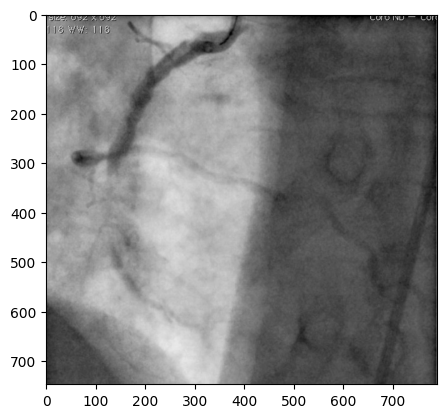

In [11]:
import os
import json

img_dir = '../Experiments/test/'

query = 'lung'
# classes = ['brain', 'abdomen', 'breast']
# classes = ['mammography', 'CT', 'X-ray', 'ultrasound']
classes = ['man', 'woman']
# classes = ['malignancy', 'cancer', 'air']

img_path = os.listdir(img_dir)[0]
# img_path = "ROCO_00001.jpg"
caption = "Axial MRI (coronal view)."
# inputs = processor(text=[query], images=None, return_tensors="jax", padding=True)
# query_vec = model.get_text_features(**inputs)
print(img_path)
# Let's load a sample image
import os
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
plt.imshow(img, aspect='equal', cmap='gray')
sentences = [f'{c} with' for c in classes]
print(sentences)

In [20]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
img_transforms = Transform(image_size=224)
pixel_values = img_transforms(torchvision.transforms.functional.pil_to_tensor(img)).numpy()
print(pixel_values.shape)
pixel_values = pixel_values.transpose((1, 2, 0))
print(pixel_values.shape)
pixel_values = pixel_values[np.newaxis, ...]
print(pixel_values.shape)
input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
                    truncation=True)
inputs = {'pixel_values': pixel_values, 'input_ids': input_toks['input_ids']}
# outputs = model(**inputs)
print(inputs.keys())
print(inputs['input_ids'].shape)
# print(inputs['input_ids'])
# print(inputs)

(3, 224, 224)
(224, 224, 3)
(1, 224, 224, 3)
dict_keys(['pixel_values', 'input_ids'])
(2, 128)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 temp_outputs = temp(**inputs)                                                                │
│   2 print(temp_outputs)                                                                          │
│   3                                                                                              │
│                                                                                                  │
│ in temp:14                                                                                       │
│                                                                                                  │
│   11 │   output_hidden_states: Optional[bool] = None,                                            │
│   12 │   return_dict: Optional[bool] = None,                                                     │
│   13 ):                                                                                          │
│ ❱ 14 │   output_attentions = output_attentions if output_attentions is not None else self.con    │
│   15 │   output_hidden_states = (                                                                │
│   16 │   │   output_hidden_states if output_hidden_states is not None else self.config.output    │
│   17 │   )                                                                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'self' is not defined

In [7]:
print(input_toks['input_ids'].shape)
print(outputs)

(2, 128)
FlaxCLIPOutput(logits_per_image=Array([[0.06180849, 0.05981767]], dtype=float32), logits_per_text=Array([[0.06180849],
       [0.05981767]], dtype=float32), text_embeds=Array([[-0.03203105,  0.00032652, -0.03433412, ..., -0.03519313,
        -0.00550837, -0.01845788],
       [-0.03158024,  0.00094946, -0.03608062, ..., -0.03479662,
        -0.00375198, -0.01869894]], dtype=float32), image_embeds=Array([[ 6.26733527e-03,  1.14934063e-02,  3.59425624e-03,
         1.25945797e-02, -7.13909185e-03, -9.68351364e-02,
         8.94185677e-02, -1.05731152e-02,  2.37940382e-02,
        -4.70324829e-02, -6.23429865e-02,  5.84093072e-02,
         5.55331856e-02,  2.79074144e-02,  1.53841646e-02,
         1.41366478e-02, -6.73577413e-02, -6.79324288e-03,
         6.10827506e-02,  8.60538334e-02, -3.53835374e-02,
         5.57067711e-03,  1.23037901e-02,  6.79372810e-03,
        -2.87202001e-02,  3.01065738e-03, -5.24985604e-03,
        -1.65417157e-02, -4.57349867e-02,  9.38723534e-02,
  

In [8]:
# sentences = [f'showing {c} in' for c in classes]
organs = ['breast', 'lung']
class_text = [f'{c} scan' for c in classes]
# sentences = [f'{organ} {t}' for organ in organs for t in class_text]

# max_seq_length = 128
# pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
# inputs = tokenizer(sentences, max_length=max_seq_length, padding="max_length", return_tensors="np",
#                     truncation=True)
# batch = {
#         "pixel_values": pixel_values,
#         "input_ids": inputs["input_ids"],
#         "attention_mask": inputs["attention_mask"],
#     }
# inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
max_length=128
inputs = processor(text=sentences, images=img, return_tensors="np", padding="max_length", max_length=max_length)
# inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
print(inputs['pixel_values'].shape)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
print(inputs['pixel_values'].shape)
print(inputs.keys())
print(inputs['input_ids'].shape)
print(inputs['input_ids'])
print(inputs['attention_mask'])
print(inputs)

(1, 3, 224, 224)
(1, 224, 224, 3)
dict_keys(['input_ids', 'attention_mask', 'pixel_values'])
(2, 128)
[[49406   786   593 49407 49407 49407 49407 49407 49407 49407 49407 49407
  49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
  49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
  49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
  49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
  49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
  49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
  49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
  49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
  49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407 49407
  49407 49407 49407 49407 49407 49407 49407 49407]
 [49406  2308   593 49407 49407 49407 49407 49407 49407 49407 49407 49407
  49407 49407 49407 49407 49407 4

In [9]:
outputs = model(**inputs)
print(outputs.logits_per_image.shape)
outputs

(1, 2)


FlaxCLIPOutput(logits_per_image=Array([[nan, nan]], dtype=float32), logits_per_text=Array([[nan],
       [nan]], dtype=float32), text_embeds=Array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), image_embeds=Array([[ 3.96958040e-03,  1.33120054e-02,  7.24213989e-03,
         1.73740201e-02, -4.99557145e-03, -9.41968635e-02,
         8.83122832e-02, -9.44821630e-03,  2.38229018e-02,
        -4.73269522e-02, -5.71980067e-02,  5.79643361e-02,
         5.37731424e-02,  2.32794825e-02,  1.67036615e-02,
         1.37930978e-02, -6.98016807e-02, -3.58923152e-03,
         5.60793839e-02,  8.88196304e-02, -3.45888063e-02,
         8.63830466e-03,  1.20371673e-02,  7.03514647e-03,
        -2.74223387e-02, -9.66778665e-04, -8.74450151e-03,
        -1.54482732e-02, -4.79628816e-02,  9.37893763e-02,
        -1.66795775e-02,  4.76847328e-02,  2.93601733e-02,
         1.38785010e-02,  7.49648223e-03,  4.23349589e-02,
         6.10591397e-02, -3.60388

In [51]:
outputs.logits_per_image.shape
outputs

FlaxCLIPOutput(logits_per_image=Array([[0.06180849, 0.05981767]], dtype=float32), logits_per_text=Array([[0.06180849],
       [0.05981767]], dtype=float32), text_embeds=Array([[-0.03203105,  0.00032652, -0.03433412, ..., -0.03519313,
        -0.00550837, -0.01845788],
       [-0.03158024,  0.00094946, -0.03608062, ..., -0.03479662,
        -0.00375198, -0.01869894]], dtype=float32), image_embeds=Array([[ 6.26733527e-03,  1.14934063e-02,  3.59425624e-03,
         1.25945797e-02, -7.13909185e-03, -9.68351364e-02,
         8.94185677e-02, -1.05731152e-02,  2.37940382e-02,
        -4.70324829e-02, -6.23429865e-02,  5.84093072e-02,
         5.55331856e-02,  2.79074144e-02,  1.53841646e-02,
         1.41366478e-02, -6.73577413e-02, -6.79324288e-03,
         6.10827506e-02,  8.60538334e-02, -3.53835374e-02,
         5.57067711e-03,  1.23037901e-02,  6.79372810e-03,
        -2.87202001e-02,  3.01065738e-03, -5.24985604e-03,
        -1.65417157e-02, -4.57349867e-02,  9.38723534e-02,
        -2.

In [38]:
probs = jax.nn.softmax(outputs.logits_per_image, axis=-1)

for c_name, prob in zip(sentences, probs[0]):
    print(f'{c_name}: {prob:.2f}')

man with: 0.50
woman with: 0.50


In [22]:
img_dir = '../Experiments/test/'

query = 'carcinoma'
img_list = os.listdir(img_dir)[:10]
imgs = [Image.open(os.path.join(img_dir, img_path)).convert('RGB') for img_path in img_list]
inputs = processor(text=[query], images=imgs, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'] #.transpose(0, 2, 3, 1)
outputs = model(**inputs)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│   5 imgs = [Image.open(os.path.join(img_dir, img_path)).convert('RGB') for img_path in img_l     │
│   6 inputs = processor(text=[query], images=imgs, return_tensors="jax", padding=True)            │
│   7 inputs['pixel_values'] = inputs['pixel_values'] #.transpose(0, 2, 3, 1)                      │
│ ❱ 8 outputs = model(**inputs)                                                                    │
│   9                                                                                              │
│                                                                                                  │
│ /home/yzhou/Development/medclip/tools/../medclip/modeling_hybrid_clip.py:192 in __call__         │
│                                                                                                  │
│   189 │   │   if dropout_rng is not None:                                                        │
│   190 │   │   │   rngs["dropout"] = dropout_rng                                                  │
│   191 │   │                                                                                      │
│ ❱ 192 │   │   return self.module.apply(                                                          │
│   193 │   │   │   {"params": params or self.params},                                             │
│   194 │   │   │   jnp.array(input_ids, dtype="i4"),                                              │
│   195 │   │   │   jnp.array(pixel_values, dtype=jnp.float32),                                    │
│                                                                                                  │
│ /home/yzhou/miniconda3/envs/medclip/lib/python3.10/site-packages/jax/_src/traceback_util.py:166  │
│ in reraise_with_filtered_traceback                                                               │
│                                                                                                  │
│   163   def reraise_with_filtered_traceback(*args, **kwargs):                                    │
│   164 │   __tracebackhide__ = True                                                               │
│   165 │   try:                                                                                   │
│ ❱ 166 │     return fun(*args, **kwargs)                                                          │
│   167 │   except Exception as e:                                                                 │
│   168 │     mode = _filtering_mode()                                                             │
│   169 │     if _is_under_reraiser(e) or mode == "off":                                           │
│                                                                                                  │
│ /home/yzhou/miniconda3/envs/medclip/lib/python3.10/site-packages/flax/linen/module.py:1538 in    │
│ apply                                                                                            │
│                                                                                                  │
│   1535 │   elif method is None:                                                                  │
│   1536 │     method = self.__call__                                                              │
│   1537 │   method = _get_unbound_fn(method)                                                      │
│ ❱ 1538 │   return apply(                                                                         │
│   1539 │   │   method, self,                                                                     │
│   1540 │   │   mutable=mutable,                                                                  │
│   1541 │   │   capture_intermediates=capture_intermediates,

In [21]:
probs = jax.nn.softmax(outputs.logits_per_text, axis=-1)

for img_name, prob in zip(img_list, probs[0]):
    print(f'{img_name}: {prob:.2f}')

ROCO_00031.jpg: nan
ROCO_00006.jpg: nan
ROCO_00138.jpg: nan
ROCO_00061.jpg: nan
ROCO_00016.jpg: nan
ROCO_00153.jpg: nan
ROCO_00001.jpg: nan
ROCO_00036.jpg: nan
ROCO_00025.jpg: nan
ROCO_00084.jpg: nan


In [213]:
# Encode a bunch of images using the model
embeddings = []
query = 'abdomen'
image_vec_file = './demo/image_embeddings.tsv'

fvec = open(image_vec_file, "w")
img_list = os.listdir(img_dir)[:20]

for idx, img_path in enumerate(img_list):
    if idx % 20 == 0:
        print(f"{idx} images processed")
    img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
    inputs = processor(images=img, return_tensors="jax", padding=True)
    inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
    img_vec = model.get_image_features(**inputs)
    img_vec = np.array(img_vec).reshape(-1)
    img_vec_s = ",".join(["{:.7e}".format(x) for x in img_vec])
    embeddings.append(np.array(img_vec).reshape(-1))
    fvec.write(f"{img_path}\t{img_vec_s}\n")

fvec.close()


0 images processed


In [212]:
import nmslib
def load_index(embedding_file):
    filenames, image_vecs = [], []
    with open(embedding_file, "r") as fvec:
        for line in fvec:
            cols = line.strip().split('\t')
            filename = cols[0]
            image_vec = np.array([float(x) for x in cols[1].split(',')])
            filenames.append(filename)
            image_vecs.append(image_vec)
    V = np.array(image_vecs)
    index = nmslib.init(method='hnsw', space='cosinesimil')
    index.addDataPointBatch(V)
    index.createIndex({'post': 2}, print_progress=True)
    return filenames, index

In [37]:
max_seq_length = 128
pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
captions = [example[1] for example in examples]
inputs = tokenizer(captions, max_length=max_seq_length, padding="max_length", return_tensors="np",
                    truncation=True)
batch = {
        "pixel_values": pixel_values,
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
    }
logits = model(**batch, train=False)[0]

torch.Size([3, 224, 224])